In [1]:
import tensorflow as tf
!pip install livelossplot

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.14.0


In [2]:
train_path=r"C:\Users\PIYUSH\Desktop\Facial exp\train"
test_path=r"C:\Users\PIYUSH\Desktop\Facial exp\test"

In [3]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(train_path,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(test_path,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same',activation='relu', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

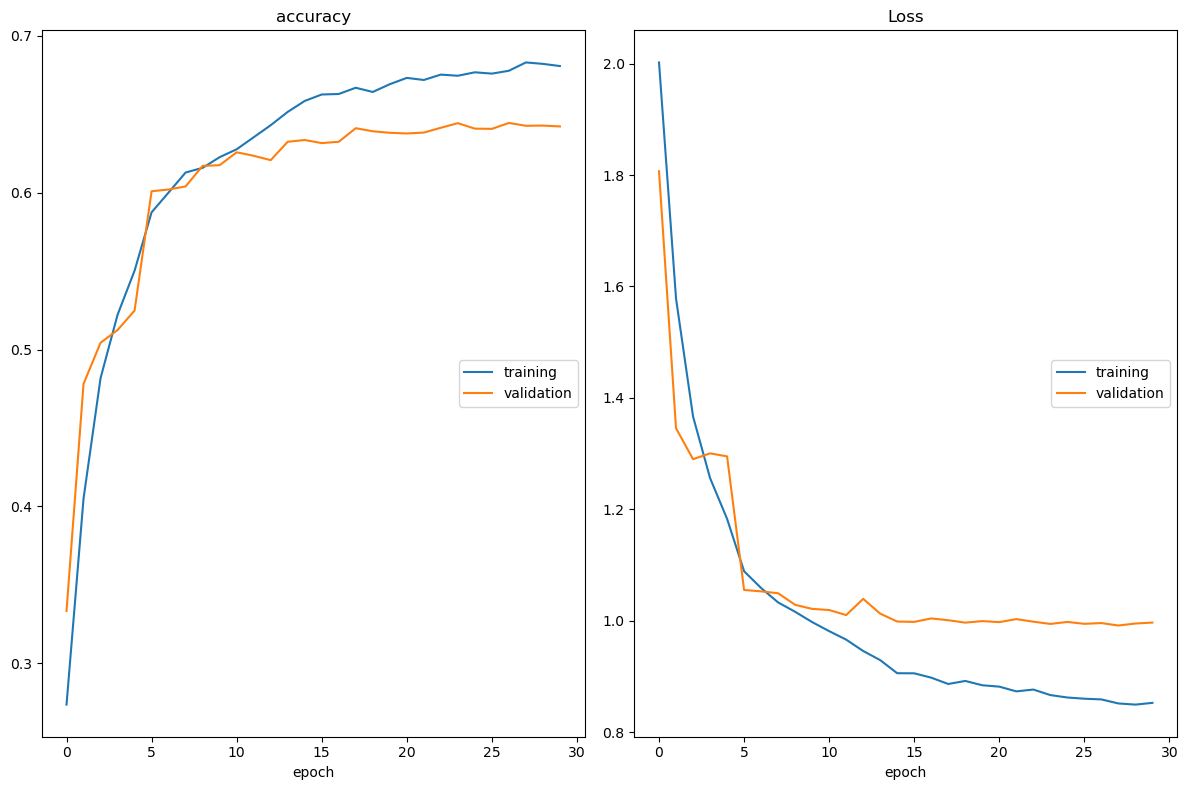

accuracy
	training         	 (min:    0.274, max:    0.683, cur:    0.681)
	validation       	 (min:    0.333, max:    0.644, cur:    0.642)
Loss
	training         	 (min:    0.850, max:    2.002, cur:    0.853)
	validation       	 (min:    0.992, max:    1.807, cur:    0.997)

Epoch 30: saving model to model_weights.h5
448/448 [==============================] - 696s 2s/step - loss: 0.8528 - accuracy: 0.6806 - val_loss: 0.9968 - val_accuracy: 0.6422 - lr: 1.0000e-05
CPU times: total: 15h 39min 14s
Wall time: 5h 58min 28s


In [9]:
%%time

epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [10]:
model.save('model2.h5')

In [11]:
model.save('kermodel2.keras')

## Predictions

In [4]:
from tensorflow.keras.models import load_model

In [6]:
test = load_model("model2.h5")

In [8]:
preds = test.predict(validation_generator)

113/113 [==============================] - 70s 621ms/step


In [18]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [13]:
predicted_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes

In [16]:
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       958
           1       0.64      0.50      0.57       111
           2       0.56      0.34      0.43      1024
           3       0.84      0.84      0.84      1774
           4       0.55      0.62      0.58      1233
           5       0.50      0.55      0.52      1247
           6       0.73      0.83      0.78       831

    accuracy                           0.64      7178
   macro avg       0.63      0.61      0.61      7178
weighted avg       0.64      0.64      0.63      7178



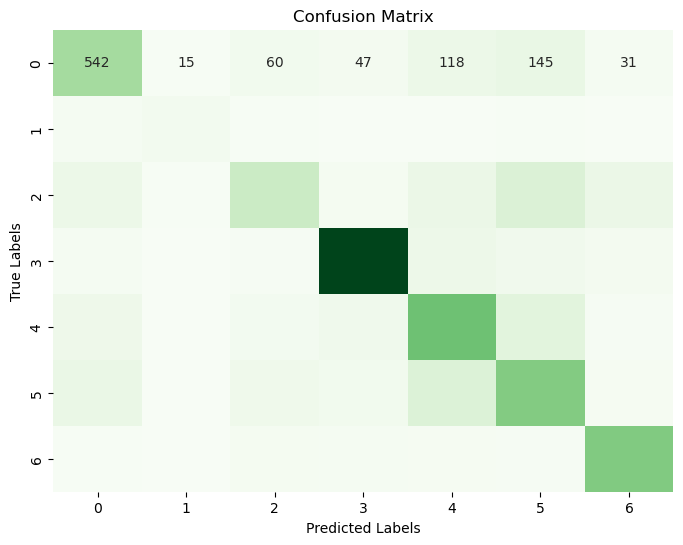

In [25]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g", cmap="Greens", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [20]:
cm

array([[ 542,   15,   60,   47,  118,  145,   31],
       [  33,   56,    7,    3,    3,    7,    2],
       [ 122,    8,  350,   38,  126,  246,  134],
       [  32,    1,   24, 1493,  109,   72,   43],
       [  96,    1,   53,   88,  765,  207,   23],
       [ 138,    5,   91,   63,  240,  685,   25],
       [  18,    1,   36,   35,   30,   19,  692]], dtype=int64)